# AXA coding challenge - data visualization and analysis
Data:
1. Citibike: https://s3.amazonaws.com/tripdata/index.html
2. NYPD:  https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [5]:
# Import modules
import os # basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn as sk
import dask.dataframe as dd

import folium # library for interactive map visualizations
from folium.plugins import HeatMap
import geopandas

In [6]:
# Functions
def plot_accidents_timeline(df, variables, period, xy_labels, plot_title, label_colours_dict, save_name):
    '''
    Function plotting one or more variables (column names) over time, taking the sum per month or year
    
    - variables: col name (str) or list of col names (str)
    - label_colours_dict: dict variable: colour -> label will be first matched to variable (col name), then taken from last part of name, eg if variable
        is 'number_of_cyclist_injured', label will be 'injured'
    - save_name: name of figure. Figure will be saved in fig_dir, as save_fig_as
    '''
    
    if period == 'month':
        period = ['year', 'month']

    # Create sum of variables per year and month
    period_sum = (
        df_accidents.groupby(period)[variables]
        .sum()
        .reset_index()
    )

    #print(monthly_sum.head()) # check 
    period_sum['date'] = pd.to_datetime(period_sum[period].assign(day=1))

    # Plot
    fig, axes = plt.subplots(len(variables),1, figsize=(12, 4*len(variables)), sharex=False); axes = axes.flatten();
    plt.suptitle(plot_title)
    for i, var in enumerate(variables):
        label = var.split('_')[-1]
        axes[i].plot(period_sum['date'], period_sum[var], marker='o', color=label_colours_dict[var], label=label)
        axes[i].set_xlabel(xy_labels[0][i])
        axes[i].set_ylabel(xy_labels[1][i])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid()
        axes[i].legend()
        plt.tight_layout()

    fig.savefig(os.path.join(fig_dir, save_name), format=save_fig_as) # save figure

def plot_combined_bike_metrics(df):
    
    df_bike_collisions = df[df['bike_involved'] == 'bike'] # filter rows where a bike is involved
    # new column to identify whether a cyclist was injured or killed
    df_bike_collisions['cyclist_hurt'] = df_bike_collisions['number_of_cyclist_injured'] + df_bike_collisions['number_of_cyclist_killed']
    
    # group by time period (year or month) and calculate the total number of collisions
    total_collisions = (df.groupby(['year', 'month']).size().reset_index(name='total_collisions'))

    # Calculate the total number of cyclists injured or killed for each month
    cyclist_hurt_by_month = (
        df_bike_collisions.groupby(['year', 'month'])['cyclist_hurt']
        .sum()
        .reset_index(name='total_cyclist_hurt')
    )

    merged_data = pd.merge(total_collisions, cyclist_hurt_by_month, on=['year', 'month'], how='left').fillna(0) # merge both dfs on year and month
    merged_data['cyclist_hurt_percentage'] = (merged_data['total_cyclist_hurt'] / merged_data['total_collisions']) * 100 #% cyclists injured or killed out of total collisions
    merged_data['date'] = pd.to_datetime(merged_data[['year', 'month']].assign(day=1))  # convert year and month to a datetime column for plotting

    bike_collision_filter = df[['bike_involved']].eq('bike').any(axis=1) # filter bike collisions
    df['is_bike_collision'] = bike_collision_filter

    # count bike collisions
    df['crash_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    monthly_totals = df.groupby('crash_month').size().reset_index(name='total_collisions')
    bike_collisions = df[df['is_bike_collision']].groupby('crash_month').size().reset_index(name='bike_collisions')

    bike_collision_data = pd.merge(monthly_totals, bike_collisions, on='crash_month', how='left').fillna(0)

    # % of bike collisions
    bike_collision_data['bike_collision_percentage'] = (bike_collision_data['bike_collisions'] / bike_collision_data['total_collisions']) * 100

    fig = plt.figure(figsize=(12, 6))

    # % collisions involving bike
    plt.plot(bike_collision_data['crash_month'], bike_collision_data['bike_collision_percentage'], marker='o', color='blue', 
             label='Percentage of bike collisions (% of total collisions)')
    # % cyclist injuries/fatalities from total collisions
    plt.plot(merged_data['date'], merged_data['cyclist_hurt_percentage'], marker='o', color='orange', 
             label='Cyclist injury/fatality (% of total collisions)')

    plt.title('Bike collisions')
    plt.xlabel('Date (year, month)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(fig_dir, 'bike_collisioms'), format=save_fig_as) # save figure
    
def color_p(pval, sign="crimson", not_sign="slategrey"): # determine colour of p value depicted in figure
    if pval < 0.05: 
        p_color = sign; 
    else:
        p_color = not_sign;
    return p_color

In [18]:
# Some settings
current_dir = os.getcwd() # current dir
cleaned_dir = current_dir + '/data/bike-tripdata_cleaned' # directory where cleaned and concatenated bike-trip data is saved
fig_dir = current_dir + '/results' # directory where figures will be saved
if not os.path.exists(fig_dir): # create if doens´t exist
    os.makedirs(fig_dir) 
    
save_fig_as = 'jpg' # save figures as, eg 'pdf', 'jpg', 'svg', 'png'

# Accident data

In [9]:
# Load accident data
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
df_accidents.columns

Index(['Unnamed: 0', 'borough', 'zip_code', 'accident_latitude',
       'accident_longitude', 'location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclists_injured',
       'number_of_cyclists_injured.1', 'number_of_motorists_injured',
       'number_of_motorists_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5',
       'crash_datetime', 'year', 'month', 'bike_involved'],
      dtype='object')

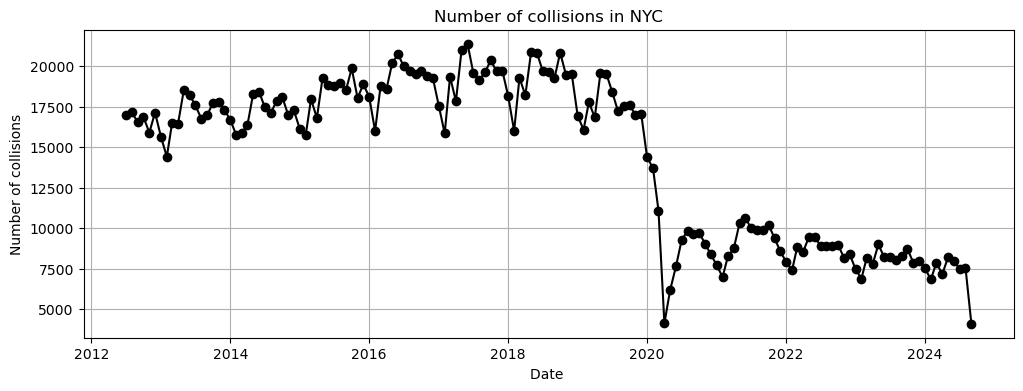

In [16]:
# Create sum of variables per year and month
monthly_count = (
    df_accidents.groupby(['year', 'month'])['number_of_cyclists_injured']
    .count()
    .reset_index()
)

monthly_count['date'] = pd.to_datetime(monthly_count[['year', 'month']].assign(day=1))

# Plot
fig, axes = plt.subplots(1,1, figsize=(12, 4), sharex=True);
axes.plot(monthly_count['date'], monthly_count['number_of_cyclists_injured'], marker='o', color='k', label='Total collisions (#)')
#axes[i].plot(monthly_accidents['date'], monthly_accidents[var], marker='o', color=label_colours_dict[var], label=label)
axes.set_xlabel('Date ')
axes.set_title('Number of collisions in NYC')
axes.set_ylabel('Number of collisions')
#axes.tick_params(axis='x', rotation=45)
axes.grid()

fig.savefig(os.path.join(fig_dir,'Monthly_collisions_total.jpg'), format='jpg') # save figure

In [21]:
variables = ['number_of_cyclists_injured','number_of_cyclists_killed','number_of_motorists_injured']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)','Date (year, month)'],['Number of cyclists injured','Number of cyclists killed','Number of motorists injured']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclists_injured':'darkorange','number_of_cyclists_killed':'red','number_of_motorists_injured':'brown'}
save_name = 'monthly_accidents.jpg'

plot_accidents_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

In [ ]:
# How many of the collisions involved a bike? And how many involved injured/killed cyclists?
# to avoid error, try: pd.options.mode.copy_on_write = True 
plot_combined_bike_metrics(df_accidents)

## Comparisons and plots
Accident data:
- over time: mortality (% collisions resulting in death)
- cyclists killed and injured /year, split by gender and age (define age groups)

Bike ride data:
- trip duration member vs casual
- what time of the day are there most trips

Combined:
- heatmap of accidents and bikes rented

# Bike ride data

In [41]:
df_rides = dd.read_parquet(cleaned_dir + '/combined_dask_df_cleaned.parquet', engine='pyarrow')
df_rides.head()

,bike_id,birth_year,end_datetime,end_station_id,end_station_latitude,end_station_longitude,end_station_name,gender,ride_id,rideable_type,start_datetime,start_station_id,start_station_latitude,start_station_longitude,start_station_name,trip_duration,user_type,year,month
0,19678.0,1983,2013-06-01 00:11:36,434.0,40.743176,-74.003662,9 Ave & W 18 St,NaN,nan,NaN,2013-06-01 00:00:01,444,40.742355,-73.989151,Broadway & W 24 St,695,member,2013,6
1,16649.0,1984,2013-06-01 00:11:41,434.0,40.743176,-74.003662,9 Ave & W 18 St,NaN,nan,NaN,2013-06-01 00:00:08,444,40.742355,-73.989151,Broadway & W 24 St,693,member,2013,6
2,19599.0,0,2013-06-01 00:35:03,406.0,40.695129,-73.995949,Hicks St & Montague St,NaN,nan,NaN,2013-06-01 00:00:44,406,40.695129,-73.995949,Hicks St & Montague St,2059,casual,2013,6
3,16352.0,1960,2013-06-01 00:03:07,262.0,40.691784,-73.973732,Washington Park,NaN,nan,NaN,2013-06-01 00:01:04,475,40.735241,-73.987587,E 15 St & Irving Pl,123,member,2013,6
4,15567.0,1983,2013-06-01 00:26:43,310.0,40.689270,-73.989128,State St & Smith St,NaN,nan,NaN,2013-06-01 00:01:22,2008,40.705692,-74.016777,Little West St & 1 Pl,1521,member,2013,6


In [ ]:
variables = ['number_of_cyclist_injured','number_of_cyclist_killed','number_of_motorist_injured']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)','Date (year, month)'],['Number of cyclists injured','Number of cyclists killed','Number of motorists injured']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclist_injured':'darkorange','number_of_cyclist_killed':'red','number_of_motorist_injured':'brown'}
save_name = 'monthly_accidents'

plot_accidents_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

# Heatmaps of bike rentals and collisions (latitude & longitude)

In [90]:
df_rides_loc['start_station_latitude']

0          40.742355
1          40.742355
2          40.695129
3          40.735241
4          40.705692
             ...    
4709255    40.742256
4709256    40.731010
4709257    40.737431
4709258    40.749943
4709259    40.747906
Name: start_station_latitude, Length: 124947806, dtype: float32

In [91]:
# drop missing values and select only coordinates from df_rides

df_rides_loc = df_rides[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']].compute().dropna()

print(df_rides_loc.head())
print(df_rides_loc.shape)

df_accidents = df_accidents.dropna(subset=['accident_latitude', 'accident_longitude'], axis=0) 

# Concatenate latitude and longitude start+stop bike station
bike_station_coord = pd.DataFrame(columns=['station_latitude','station_longitude'])
bike_station_coord['station_latitude'] = pd.concat([df_rides_loc['start_station_latitude'],df_rides_loc['end_station_latitude']])
bike_station_coord['station_longitude'] = pd.concat([df_rides_loc['start_station_longitude'],df_rides_loc['end_station_longitude']])

bike_station_coord.head() # check
print(bike_station_coord.shape)

,station_latitude,station_longitude
0,40.742355,-73.989151
1,40.742355,-73.989151
2,40.695129,-73.995949
3,40.735241,-73.987587
4,40.705692,-74.016777


In [51]:
print(f'Latitude, min: {df_accidents["accident_latitude"].min()}, max: {df_accidents["accident_latitude"].max()}')
print(f'Longitude, min: {df_accidents["accident_longitude"].min()}, max: {df_accidents["accident_longitude"].max()}')

Latitude, min: 0.0, max: 43.344444
Longitude, min: -201.35999, max: 0.0


-> strange: the coordinates of NYC are more or less: 40.941152, -74.229631, 40.475906, -74.298043, 40.462523, -73.733154, 41.014935, -73.586557 (when
drawing a square around it). This must explain the few outliers, visible in Europe and even in weirder places. Why? No time now though to figure it out & filter them out

In [22]:
# Create a map with the accident density overlaid

m_accidents = folium.Map(location=[df_accidents['accident_latitude'].median(), df_accidents['accident_longitude'].median()], zoom_start=10)  
accidents_coords = list(zip(df_accidents['accident_latitude'], df_accidents['accident_longitude']))
#HeatMap(accidents_coords, radius=20, blur=25, max_zoom=1).add_to(m_accidents)
HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents)

#from folium import IFrame # notebook works too slow
# title = IFrame('<h3>Accidents Heatmap</h3>', width=200, height=50)
# popup = folium.Popup(title)
# folium.Marker(location=[df_accidents['accident_latitude'].mean(), df_accidents['accident_longitude'].mean()], popup=popup).add_to(m_accidents)

m_accidents # show

try:
    m_accidents.save(os.path.join(fig_dir, 'map_accidents.html')) # save
    print("Map saved successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

#del m_rides # to clear up memory

In [ ]:
# create a map of NYC with the center coordinates [median lat, median long] of the dataset
m_rides = folium.Map(location=[bike_station_coord['station_latitude'].median(), 
                               bike_station_coord['station_longitude'].median()], zoom_start=10) 
rides_coords = list(zip(bike_station_coord['station_latitude'], bike_station_coord['station_longitude']))
HeatMap(rides_coords, radius=15, blur=20, max_zoom=1).add_to(m_rides) # add the heatmap to map

m_rides # show

m_rides.save(os.path.join(fig_dir, 'map_bike-rides.html')) # save

#del m_rides # to clear up memory

### Create a map with the bike ride density overlaid

In [ ]:
# m_accidents = folium.Map(location=[df_accidents['accident_latitude'].median(), df_accidents['accident_longitude'].median()], zoom_start=10)  
# accidents_coords = list(zip(df_accidents['accident_latitude'], df_accidents['accident_longitude']))
# HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents)
# rides_coords = list(zip(bike_station_coord['station_latitude'], bike_station_coord['station_longitude'])) 

HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents) # add the heatmap to accident map

m_accidents # show

m_accidents.save(os.path.join(fig_dir, 'map_accidents_bike-stations_overlay.html'))

#del m_rides m_accidents

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

# Plot for accidents
plt.subplot(1, 3, 1)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True)
plt.title('Accidents Density')

# Plot for bike rides
plt.subplot(1, 3, 2)
sns.kdeplot(data=rides_coords, x='station_longitude', y='station_latitude', fill=True)
plt.title('bike station use density')

# Overlay
plt.subplot(1, 3, 3)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True, color='red', alpha=0.5)
sns.kdeplot(data=df_rides_pd, x='end_longitude', y='end_latitude', fill=True, color='blue', alpha=0.5)
plt.title('Overlay of accidents and bike station use density')

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(fig_dir, 'density_plot_accidents_bike-rides'))